In [108]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import os

In [109]:
file1 = open('data/Flickr8k_text/Flickr8k.token.txt', 'r')
Lines = file1.readlines()
  
count = 0

pictures = []
cap_nums = []
descs = []

for line in Lines:
    count += 1
    words = line.split()
    words = [i.lower() for i in words]
    words = [i for i in words if i != "a"]
    csv_clean = [0] * 2
    pictures.append(words[0].split("#")[0])
    cap_nums.append(words[0].split("#")[1])

    descs.append(" ".join(words[1:][:-1]))

In [110]:
df = pd.DataFrame()
df["pictures"] = pictures
df["caption_number"] = cap_nums
df["caption"] = descs

In [111]:
df

,pictures,caption_number,caption
0,1000268201_693b08cb0e.jpg,0,child in pink dress is climbing up set of stai...
1,1000268201_693b08cb0e.jpg,1,girl going into wooden building
2,1000268201_693b08cb0e.jpg,2,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,3,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,4,little girl in pink dress going into wooden cabin
...,...,...,...
40455,997722733_0cb5439472.jpg,0,man in pink shirt climbs rock
40456,997722733_0cb5439472.jpg,1,man is rock climbing high in the air
40457,997722733_0cb5439472.jpg,2,person in red shirt climbing up rock face cove...
40458,997722733_0cb5439472.jpg,3,rock climber in red shirt


In [112]:
len(df["pictures"].unique())

8092

In [113]:
print("Number of captions with less than 2 words:", sum([1 if len(i.split()) < 2 else 0 for i in df["caption"]]))
print("Number of captions with less than 1 words:", sum([1 if len(i.split()) < 1 else 0 for i in df["caption"]]))

Number of captions with less than 2 words: 36
Number of captions with less than 1 words: 6


In [114]:
drop_index = np.where(np.array([1 if len(i.split()) < 1 else 0 for i in df["caption"]]) == 1)[0]

In [115]:
drop_index

array([ 9310, 20327, 21255, 23231, 33365, 34530])

In [116]:
df = df[~df.index.isin(drop_index)]

In [117]:
df["caption"] = 'START ' + df['caption'].astype(str) + ' END' 

/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_3860/739485099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["caption"] = 'START ' + df['caption'].astype(str) + ' END'


In [118]:
df

,pictures,caption_number,caption
0,1000268201_693b08cb0e.jpg,0,START child in pink dress is climbing up set o...
1,1000268201_693b08cb0e.jpg,1,START girl going into wooden building END
2,1000268201_693b08cb0e.jpg,2,START little girl climbing into wooden playhou...
3,1000268201_693b08cb0e.jpg,3,START little girl climbing the stairs to her p...
4,1000268201_693b08cb0e.jpg,4,START little girl in pink dress going into woo...
...,...,...,...
40455,997722733_0cb5439472.jpg,0,START man in pink shirt climbs rock END
40456,997722733_0cb5439472.jpg,1,START man is rock climbing high in the air END
40457,997722733_0cb5439472.jpg,2,START person in red shirt climbing up rock fac...
40458,997722733_0cb5439472.jpg,3,START rock climber in red shirt END


In [119]:
vocab = list(df['caption'].str.split(' ', expand=True).stack().value_counts().index)

In [120]:
vocab_size = len(vocab)

In [121]:
vocab_size

8845

In [122]:
from nltk.tokenize import word_tokenize

df['caption'].apply(word_tokenize)


0        [START, child, in, pink, dress, is, climbing, ...
1        [START, girl, going, into, wooden, building, END]
2        [START, little, girl, climbing, into, wooden, ...
3        [START, little, girl, climbing, the, stairs, t...
4        [START, little, girl, in, pink, dress, going, ...
                               ...                        
40455     [START, man, in, pink, shirt, climbs, rock, END]
40456    [START, man, is, rock, climbing, high, in, the...
40457    [START, person, in, red, shirt, climbing, up, ...
40458          [START, rock, climber, in, red, shirt, END]
40459    [START, rock, climber, practices, on, rock, cl...
Name: caption, Length: 40454, dtype: object

In [123]:
import itertools

# converting text to intergers
corpus = list(df["caption"])
token_docs = [doc.split() for doc in corpus]
all_tokens = set([word for sentence in token_docs for word in sentence])
word_to_idx = {token:idx+1 for idx, token in enumerate(all_tokens)}
# converting the docs to their token ids
X = np.array([[word_to_idx[token] for token in token_doc] for token_doc in token_docs], dtype=object)
# padding the sequences
# X_padded = pad_sequences(X, padding="post")
# # converting to pandas df
# X_df = pd.DataFrame(X_padded) 
pad_token = 0

X = zip(*itertools.zip_longest(*X, fillvalue=pad_token))
X_df = pd.DataFrame(X) 

In [124]:
X_df

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,2862,6826,7921,6249,6764,4247,7331,5220,55,3911,...,0,0,0,0,0,0,0,0,0,0
1,2862,30,6501,3012,3144,6353,4541,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2862,1186,30,7331,3012,3144,4898,4541,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2862,1186,30,7331,4137,764,4887,2111,4898,4541,...,0,0,0,0,0,0,0,0,0,0
4,2862,1186,30,7921,6249,6764,6501,3012,3144,1977,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40449,2862,934,7921,6249,8120,787,410,4541,0,0,...,0,0,0,0,0,0,0,0,0,0
40450,2862,934,4247,410,7331,6795,7921,4137,296,4541,...,0,0,0,0,0,0,0,0,0,0
40451,2862,6594,7921,4825,8120,7331,5220,410,2411,5623,...,0,0,0,0,0,0,0,0,0,0
40452,2862,410,3058,7921,4825,8120,4541,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
word_to_idx["END"]

4541

In [134]:
word_to_idx["PAD"] = 0
word_to_idx["UNKNOWN"] = vocab_size+1

In [136]:
word_to_idx["UNKNOWN"]

8846

In [137]:
idx_to_word = {v: k for k, v in word_to_idx.items()}

In [142]:
vocab_size

8845

In [143]:
max_length = X_df.shape[1]

In [144]:
vocab_size, max_length

(8845, 36)

In [127]:
from torchvision.models import resnet50, ResNet50_Weights

In [128]:
from PIL import Image
import torchvision
import torch

#input_image = Image.open("car.jpeg")
#input_image = Image.open("data/Flicker8k_Dataset/997722733_0cb5439472.jpg")
input_image = Image.open("car.jpeg").convert("RGB")

#input_image = Image.open("DINNER.png").convert("RGB")
#input_image = Image.open("Screen Shot 2022-11-23 at 10.33.41 PM.png").convert("RGB")
def preprocess_image(input_image):

    preprocess = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),

        torchvision.transforms.RandomHorizontalFlip(),

        torchvision.transforms.ToTensor(),

        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(input_image)
    input_tensor = torch.unsqueeze(input_tensor, 0)
    return input_tensor
    


In [129]:
import torch

In [52]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = torch.nn.Sequential(*list(torchvision.models.resnet50(weights = ResNet50_Weights.DEFAULT).children())[:-1])

    def forward(self, input_tensor):
        return self.layers(input_tensor).squeeze(2).squeeze(2)

In [53]:
model = CNN()
input_tensor = preprocess_image(input_image=input_image)
pred = model(input_tensor)
pred.shape

torch.Size([1, 2048])

In [54]:
pred

tensor([[0.0125, 0.2141, 0.1888,  ..., 0.0074, 0.0000, 0.0820]],
       grad_fn=<SqueezeBackward1>)

In [35]:
glove_embeddings = pd.DataFrame()
glove = open("glove.6B/glove.6B.50d.txt", encoding="utf-8")
words = []
embeddings = []
for embedding in glove:
    words.append(embedding.split()[0])
    vector = np.asarray(embedding.split()[1:], dtype='float32')
    embeddings.append(vector)

glove_embeddings["word"] = words
glove_embeddings["embedding"] = embeddings

In [36]:
glove_embeddings

,word,embedding
0,the,"[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -0..."
1,",","[0.013441, 0.23682, -0.16899, 0.40951, 0.63812..."
2,.,"[0.15164, 0.30177, -0.16763, 0.17684, 0.31719,..."
3,of,"[0.70853, 0.57088, -0.4716, 0.18048, 0.54449, ..."
4,to,"[0.68047, -0.039263, 0.30186, -0.17792, 0.4296..."
...,...,...
399995,chanty,"[0.23204, 0.025672, -0.70699, -0.045465, 0.139..."
399996,kronik,"[-0.60921, -0.67218, 0.23521, -0.11195, -0.460..."
399997,rolonda,"[-0.51181, 0.058706, 1.0913, -0.55163, -0.1024..."
399998,zsombor,"[-0.75898, -0.47426, 0.4737, 0.7725, -0.78064,..."


In [37]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [39]:
word_to_idx

{'sends': 1,
 'shoveling': 2,
 'river': 3,
 'vegetation': 4,
 'turf': 5,
 'opened': 6,
 'cross-walk': 7,
 'notes': 8,
 'snowed': 9,
 'purchasing': 10,
 'tells': 11,
 'mani': 12,
 'country': 13,
 'searching': 14,
 'crystal': 15,
 'manicured': 16,
 'downriver': 17,
 'leaving': 18,
 'questioningly': 19,
 'wipes': 20,
 'out': 21,
 'dogsled': 22,
 'gnawing': 23,
 'glittery': 24,
 'retriving': 25,
 'board': 26,
 'spar': 27,
 'fabric': 28,
 'cello': 29,
 'girl': 30,
 'recently': 31,
 'tatoo': 32,
 'high-rise': 33,
 'arched': 34,
 'smile': 35,
 'violently': 36,
 'swim': 37,
 'windbreaker': 38,
 'poofy': 39,
 'defend': 40,
 'pine': 41,
 'explorer': 42,
 'ourdoors': 43,
 'evening': 44,
 'waters': 45,
 'boys': 46,
 'jungle': 47,
 'pipes': 48,
 'multi-color': 49,
 'checkerboard': 50,
 'darkly': 51,
 'curls': 52,
 'armbands': 53,
 'hoists': 54,
 'set': 55,
 'brake': 56,
 'pinstripe': 57,
 'attrative': 58,
 'nine': 59,
 'chase': 60,
 're': 61,
 'metro': 62,
 'know': 63,
 'synchronized': 64,
 'mortar

In [40]:
glove_embeddings.iloc[glove_embeddings.word.map(word_to_idx).argsort()].sort_index()


,word,embedding
0,the,"[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -0..."
1,",","[0.013441, 0.23682, -0.16899, 0.40951, 0.63812..."
2,.,"[0.15164, 0.30177, -0.16763, 0.17684, 0.31719,..."
3,of,"[0.70853, 0.57088, -0.4716, 0.18048, 0.54449, ..."
4,to,"[0.68047, -0.039263, 0.30186, -0.17792, 0.4296..."
...,...,...
399999,sandberger,"[0.072617, -0.51393, 0.4728, -0.52202, -0.3553..."
399999,sandberger,"[0.072617, -0.51393, 0.4728, -0.52202, -0.3553..."
399999,sandberger,"[0.072617, -0.51393, 0.4728, -0.52202, -0.3553..."
399999,sandberger,"[0.072617, -0.51393, 0.4728, -0.52202, -0.3553..."


In [41]:
glove_embeddings

,word,embedding
0,the,"[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -0..."
1,",","[0.013441, 0.23682, -0.16899, 0.40951, 0.63812..."
2,.,"[0.15164, 0.30177, -0.16763, 0.17684, 0.31719,..."
3,of,"[0.70853, 0.57088, -0.4716, 0.18048, 0.54449, ..."
4,to,"[0.68047, -0.039263, 0.30186, -0.17792, 0.4296..."
...,...,...
399995,chanty,"[0.23204, 0.025672, -0.70699, -0.045465, 0.139..."
399996,kronik,"[-0.60921, -0.67218, 0.23521, -0.11195, -0.460..."
399997,rolonda,"[-0.51181, 0.058706, 1.0913, -0.55163, -0.1024..."
399998,zsombor,"[-0.75898, -0.47426, 0.4737, 0.7725, -0.78064,..."


In [42]:
for i in glove_embeddings[glove_embeddings['word'].isin(vocab)]

SyntaxError: invalid syntax (476955084.py, line 1)

In [43]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

NameError: name 'wordtoix' is not defined

In [44]:
word_to_idx

{'sends': 1,
 'shoveling': 2,
 'river': 3,
 'vegetation': 4,
 'turf': 5,
 'opened': 6,
 'cross-walk': 7,
 'notes': 8,
 'snowed': 9,
 'purchasing': 10,
 'tells': 11,
 'mani': 12,
 'country': 13,
 'searching': 14,
 'crystal': 15,
 'manicured': 16,
 'downriver': 17,
 'leaving': 18,
 'questioningly': 19,
 'wipes': 20,
 'out': 21,
 'dogsled': 22,
 'gnawing': 23,
 'glittery': 24,
 'retriving': 25,
 'board': 26,
 'spar': 27,
 'fabric': 28,
 'cello': 29,
 'girl': 30,
 'recently': 31,
 'tatoo': 32,
 'high-rise': 33,
 'arched': 34,
 'smile': 35,
 'violently': 36,
 'swim': 37,
 'windbreaker': 38,
 'poofy': 39,
 'defend': 40,
 'pine': 41,
 'explorer': 42,
 'ourdoors': 43,
 'evening': 44,
 'waters': 45,
 'boys': 46,
 'jungle': 47,
 'pipes': 48,
 'multi-color': 49,
 'checkerboard': 50,
 'darkly': 51,
 'curls': 52,
 'armbands': 53,
 'hoists': 54,
 'set': 55,
 'brake': 56,
 'pinstripe': 57,
 'attrative': 58,
 'nine': 59,
 'chase': 60,
 're': 61,
 'metro': 62,
 'know': 63,
 'synchronized': 64,
 'mortar

In [56]:
# embedding_layer = torch.nn.Embedding(vocab_size, max_length)

In [ ]:
# embeddings = self.embed(captions)

In [55]:
# pred

tensor([[0.0125, 0.2141, 0.1888,  ..., 0.0074, 0.0000, 0.0820]],
       grad_fn=<SqueezeBackward1>)

In [ ]:
# features = pred.unsqueeze(1)
# embeddings = torch.cat((features, embeddings[:, :-1,:]), dim=1)

In [45]:
class LSTM():
    def __init__(self, vocab_size = vocab_size, embedding_size = max_length, hidden_size = 256, num_layers = 1, dropout = .2):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output = vocab_size

        self.linear = torch.nn.Linear(2048, 256)
        self.relu = torch.nn.ReLU()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_size)

        self.lstm = torch.nn.LSTM(embedding_size, num_layers = self.num_layers, hidden_size=self.hidden_size)
        
        #self.output = torch.nn.Softmax(self.hidden_size, self.output_size)
        self.output = torch.nn.Linear(self.hidden_size,self.output_size)


    def forward(self, features, captions):
        hidden = (torch.zeros(self.num_layers, features.shape[0], self.hidden_size), torch.zeros(self.num_layers, features.shape[0], self.hidden_size))
        embeddings = self.embedding(self.embedding(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        lstm_out, _ = self.lstm(embeddings, hidden)
        return self.output(lstm_out)



In [59]:
X_df

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,6824,7919,6247,6762,4246,7329,5218,55,3910,764,...,0,0,0,0,0,0,0,0,0,0
1,30,6499,3011,3143,6351,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1186,30,7329,3011,3143,4896,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1186,30,7329,4136,764,4885,2111,4896,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1186,30,7919,6247,6762,6499,3011,3143,1977,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40449,934,7919,6247,8118,787,410,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40450,934,4246,410,7329,6793,7919,4136,296,0,0,...,0,0,0,0,0,0,0,0,0,0
40451,6592,7919,4823,8118,7329,5218,410,2411,5621,7919,...,0,0,0,0,0,0,0,0,0,0
40452,410,3057,7919,4823,8118,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
idx_to_word[6824]

'child'

{'sends': 1,
 'shoveling': 2,
 'river': 3,
 'vegetation': 4,
 'turf': 5,
 'opened': 6,
 'cross-walk': 7,
 'notes': 8,
 'snowed': 9,
 'purchasing': 10,
 'tells': 11,
 'mani': 12,
 'country': 13,
 'searching': 14,
 'crystal': 15,
 'manicured': 16,
 'downriver': 17,
 'leaving': 18,
 'questioningly': 19,
 'wipes': 20,
 'out': 21,
 'dogsled': 22,
 'gnawing': 23,
 'glittery': 24,
 'retriving': 25,
 'board': 26,
 'spar': 27,
 'fabric': 28,
 'cello': 29,
 'girl': 30,
 'recently': 31,
 'tatoo': 32,
 'high-rise': 33,
 'arched': 34,
 'smile': 35,
 'violently': 36,
 'swim': 37,
 'windbreaker': 38,
 'poofy': 39,
 'defend': 40,
 'pine': 41,
 'explorer': 42,
 'ourdoors': 43,
 'evening': 44,
 'waters': 45,
 'boys': 46,
 'jungle': 47,
 'pipes': 48,
 'multi-color': 49,
 'checkerboard': 50,
 'darkly': 51,
 'curls': 52,
 'armbands': 53,
 'hoists': 54,
 'set': 55,
 'brake': 56,
 'pinstripe': 57,
 'attrative': 58,
 'nine': 59,
 'chase': 60,
 're': 61,
 'metro': 62,
 'know': 63,
 'synchronized': 64,
 'mortar

In [ ]:
input_tensor = torch.unsqueeze(input_tensor, 0)
model = torchvision.models.resnet50(weights = ResNet50_Weights.DEFAULT)
model.eval()
preds = model(input_tensor)

In [107]:
probabilities = torch.nn.functional.softmax(preds[0], dim=0)

In [108]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

ski mask 0.05998014286160469
crash helmet 0.05567425116896629
car mirror 0.049926143139600754
motor scooter 0.04191206023097038
torch 0.024757830426096916


In [119]:
list(resnet50().children())[:-1]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

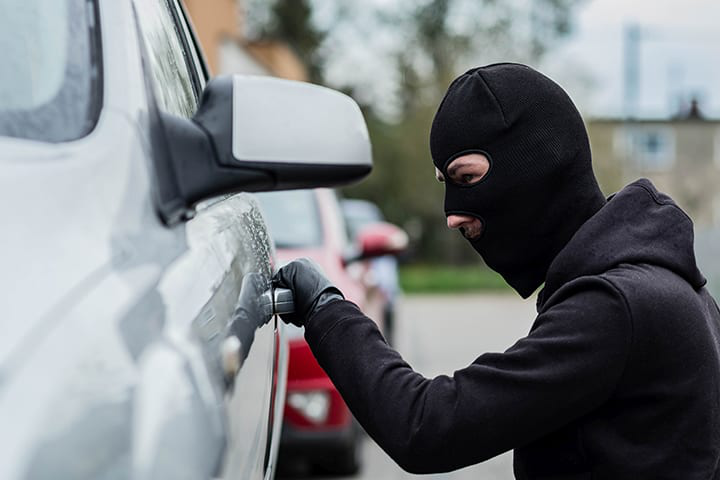

In [109]:
from PIL import Image

img = Image.open("car_jack.jpeg")
img

/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/rudra/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

: 

: 

In [ ]:
resnet("")